In [216]:
library(dplyr)
library(ggplot2)
library(GGally)
library(reshape2)

In [123]:
#for simplicity, have one hyperparameters object that contains all variables
get_default_hyperparameters <- function(){
    
    hyperparameters <- list()
    
    #dataset-specific settings:
    attr(hyperparameters, "main_url") <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/"
    attr(hyperparameters, "files")    <- c("winequality-red.csv", "winequality-white.csv")
    attr(hyperparameters, "response_name") <- "quality"
    
    
    attr(hyperparameters, "ensemble_K")  <- 5
    #number of folds of cross-validation for evaluating entire ensembles
    attr(hyperparameters, "top_level_repeats") <- 10
    #number of repeats to perform at top level (evaluating entire ensemble-forming strategy)
    attr(hyperparameters, "ensemble_size") <- 3
    attr(hyperparameters, "n_attempts") <- 10
    attr(hyperparameters, "single_model_K") <- 5
    #number of folds of cross-validation for finding single models
    attr(hyperparameters, "retest_predictors") <- FALSE
    attr(hyperparameters, "weight_by_scores") <- TRUE
    attr(hyperparameters, "run_standard_model") <- FALSE
    attr(hyperparameters, "new_features") <- FALSE
    return(hyperparameters)
}

In [120]:
#this function does all preprocessing (normalization etc.)
#and defines new features by applying transformations
preprocess <- function(data, response_name, hyperparameters=get_default_hyperparameters()){
    
    #separate into response and predictors
    response <- data[[response_name]]
    predictors <- data
    predictors[[response_name]] <- NULL
        
    #z-score predictors
    znorm <- function(x)  (x - mean(x))/ sd(x)
    predictors <- apply(predictors, 2, znorm)
    
    predictors <- as.data.frame(predictors)
    
    #define new features
    if(attr(hyperparameters, "new_features")){
        original_features <- colnames(predictors)
        for(i in 1:length(original_features)){
            f <- original_features[[i]]
            predictors[[paste("log.",f,sep='')]] <- log(predictors[[f]] - min(predictors[[f]]) + 1)
            predictors[[paste("sqrt.",f,sep='')]] <- sqrt(predictors[[f]] - min(predictors[[f]]))
            predictors[[paste("inv.",f,sep='')]] <- 1/(predictors[[f]] - min(predictors[[f]] + 1))
        }
    }
    
    
    
    #combine into single matrix again
    data <- cbind(response, predictors)
    colnames(data)[1] <- "y"
    
    return(data)
    
}

In [76]:
run_ensemble <- function(ensemble_models, data, scores=NULL, hyperparameters=get_default_hyperparameters(), verbose=FALSE){
    
    weight_by_scores <- attr(hyperparameters, "weight_by_scores")
    
    ensemble_size <- length(ensemble_models)
    predictions <- vector("list", ensemble_size)
    for (n in 1:ensemble_size){
        if(verbose){
            print(paste("running model", n, "/", ensemble_size, sep=" "))
        }
        predictions[[n]] <- predict(ensemble_models[[n]], newdata=data)
    }
    predictions_matrix <- t(Reduce(rbind, predictions))
    
    weights = rep(1/length(ensemble_models), length(ensemble_models))
    if(length(scores)>0 && weight_by_scores){
        weights = -log(scores)
        weights = weights/sum(weights)
    }
    else{
        #assume NULL was passed for scores
        weights = rep(1/length(ensemble_models), length(ensemble_models))
    }
    weighted_avg <- rep(0, nrow(data))
    for (n in 1:ensemble_size){    
        weighted_avg <- weighted_avg + weights[n]*predictions_matrix[,n]
    }
    
    return(weighted_avg)
}

In [77]:
train_ensemble <- function(ensemble_definition, data, hyperparameters=get_default_hyperparameters(), verbose=FALSE){
    ensemble_size <- length(ensemble_definition)
    ensemble_models <- vector("list", ensemble_size)
    
    for (n in 1:ensemble_size){
        if(verbose){
            print(paste("training model", n, "/", ensemble_size, sep=" "))
        }
        modelspec <- ensemble_definition[[n]]
        train_data <- as.data.frame(cbind(data$y, data[,modelspec]))
        colnames(train_data)[1] <- "y"
        ensemble_models[[n]] <- lm(y ~ (.)^2, data=train_data)
    }
    
    return(ensemble_models)
}

In [47]:
find_ensemble <- function(data, hyperparameters=get_default_hyperparameters(), verbose=FALSE){
    
    
    ensemble_size <- attr(hyperparameters, "ensemble_size")
    ensemble = vector("list", ensemble_size)
    scores = rep(0, ensemble_size)
    
    for (n in 1:ensemble_size){
    
        if(verbose){
            print(paste("finding model", n, "/", ensemble_size, sep=" "))
        }
        outputs <- find_single_model(data, hyperparameters=hyperparameters, verbose=verbose)
        scores[n] <- outputs[[1]]
        ensemble[[n]] <- outputs[[2]]
    }
    return(list(scores, ensemble))
}

In [129]:
#find a single model
#to serve as part of an ensemble
#return set of predictors used for that model
find_single_model <- function(data, hyperparameters=get_default_hyperparameters(), verbose=FALSE){
    
    K <- attr(hyperparameters, "single_model_K")
    CV_folds   <- get_CV_folds(nrow(data), K)
    train_indices <- CV_folds[[1]]
    test_indices <- CV_folds[[2]]
    n_attempts <- attr(hyperparameters, "n_attempts")
    retest <- attr(hyperparameters, "retest_predictors")
    
    response <- data$y
    predictors <- data
    predictors[["y"]] <- NULL
    
    
    predictor_set <- c()
    best_predictor_set <- c()
    tested_predictors <- c()
    best_score <- Inf
    
    null_model_score <- 0
    
    for(n in 1:n_attempts){
        
        
        current_predictor_set <- best_predictor_set
        
        #for the first iteration, run the empty model
        #to get performance of intercept
        #after first iteration, add predictors to model
        if(n > 1){
            all_predictors <- colnames(predictors)
            unused_predictors <- c()
            for(j in 1:length(all_predictors)){
                p <- all_predictors[[j]]
                if(!( p %in% current_predictor_set) && (retest || !(p %in% tested_predictors))){
                    unused_predictors <- c(unused_predictors, p)
                }
            }
            if(length(unused_predictors) < 1){
                break;
                #exit loop over n_attempts
            }
            p <- sample(unused_predictors, 1, replace=FALSE)
            current_predictor_set <- c(current_predictor_set, p)
            tested_predictors <- p
        }
        if(verbose){
            print(paste("Evaluating model:", paste(current_predictor_set, sep=" ", collapse=", "), sep=" "))
        }
        
        oof_scores <- rep(0, K)
        
        
        for(k in 1:K){
            if(length(current_predictor_set)==0){
                #empty model - just use mean as intercept
                train_Y <- response[train_indices[[k]]]
                test_Y  <- response[test_indices[[k]]] 
                prediction <- mean(train_Y)
                oof_scores[k] <- mean(abs(test_Y - prediction))
            }
            else{
                train_X <- predictors[train_indices[[k]],current_predictor_set]
                test_X  <- predictors[test_indices[[k]],current_predictor_set]
                train_Y <- response[train_indices[[k]]]
                test_Y  <- response[test_indices[[k]]] 
                
                train_data <- as.data.frame(cbind(train_Y, train_X))
                test_data <- as.data.frame(cbind(test_Y, test_X))
                colnames(train_data)[1] <- "y"
                colnames(test_data)[1] <- "y"

                model  <- lm(y ~ (.)^2, data=train_data)
            
                oof_scores[k] <- mean(abs(test_data$y- predict(model, newdata=test_data)))
            }

        }#end loop over folds
        
        if(length(current_predictor_set)==0){
            null_model_score <- mean(oof_scores)
        }
        
        
        #if the model is an improvement over previous best, update it
        final_score <- mean(oof_scores)
        
        if(final_score < best_score){
            output_message = "Keeping model"
            best_score <- final_score
            best_predictor_set <- current_predictor_set
        }
        else{
            output_message = "Discarding model"
        }
        if(verbose){
            print(paste("Model score =", final_score, sep=" "))
            print(output_message)
        }
    }
    
    
    #return description of this model
    #as a list of predictor names (strings)
    return(list(best_score/null_model_score, best_predictor_set))
}

In [9]:
#check if data files are present in local directory
#if they are not, try to download
#return 1 if files are now present locally (either found or successfully downloaded)
#return 0 otherwise
#if this returns 1, we expect a subsequent call to read_data to succeed
find_or_download_data <- function (main_url, files){

    for (i in 1:length(files)){
        if(!file.exists(files[i])){
            print(paste("Could not find", files[i], "- attempting to download", sep=" " ))
            download.file(paste(main_url, files[i],sep="") , files[i], "auto", quiet = FALSE)
        }
    }
    for (i in 1:length(files)){
        if(!file.exists(files[i])){
            print(paste("Could not find or download", files[i], "- training will fail", sep=" " ))
            return(0)
        }
    }
    return(1)
}

In [204]:
#read data from .csv files to data.frame
#merge multiple .csv into one (binds rows)
#add a one-hot encoding of the file number
read_data <- function(files){
    single_datasets <- vector("list", length(files))
    for (i in 1:length(files)){
        single_datasets[[i]] <- read.csv(files[i], header=TRUE, sep=";")
        single_datasets[[i]]$file.number <- i
    }
    data <- bind_rows(single_datasets) 
    #bind_rows : dplyr function
    
    #data is now full dataset (merged across all files)
        
    #make one-hot encoding of file number
    u <- unique(data$file.number)
    for (val in u[1:(length(u)-1)]){
        data[paste("file.number.",val,sep="")] <- (data$file.number==val)*1.0
    }
    data$file.number <- NULL
    #remove initial (categorical) file number column
    return(data)
}

In [10]:
get_CV_folds <- function(N, K){
    train_indices <- vector("list", K)
    test_indices  <- vector("list", K)
    random_permutation <- sample(N, N, replace=FALSE)
    for (i in 1:K){
        start <- floor(N*(i-1)/K) + 1
        stop  <- floor(N*i/K)
        test_indices[[i]] <-  random_permutation[start:stop]
        train_indices[[i]] <- random_permutation[-(start:stop)]
    }
    return(list(train_indices, test_indices))
}

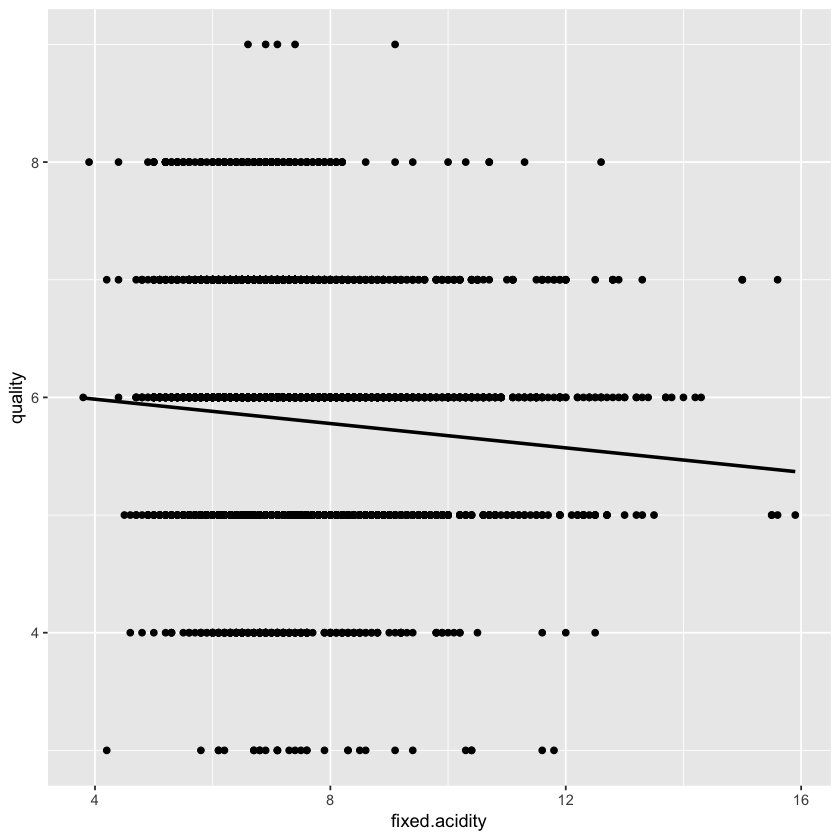

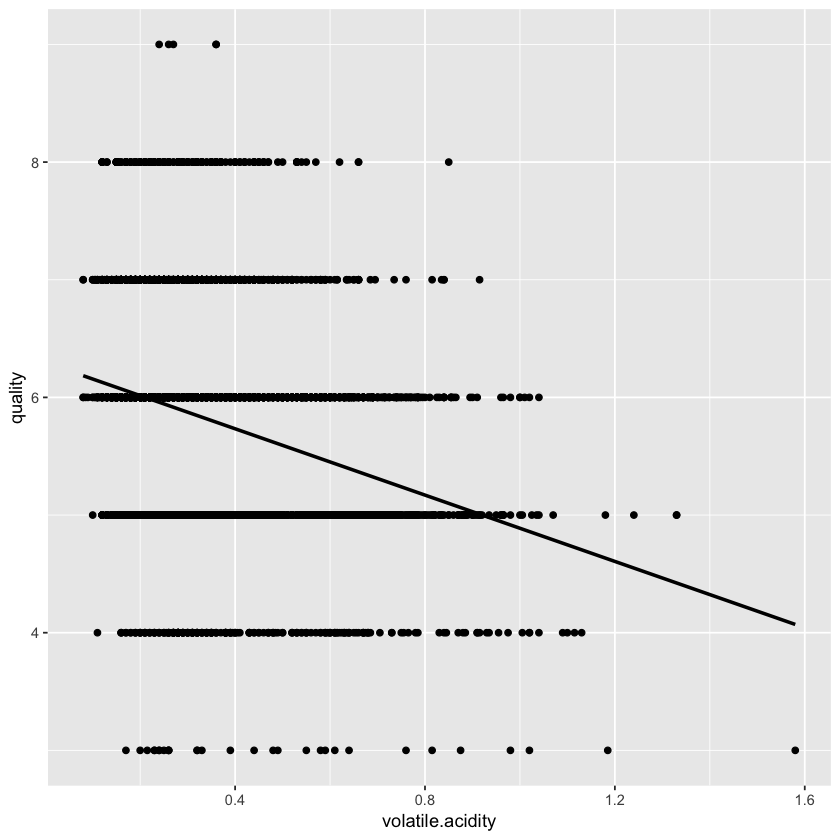

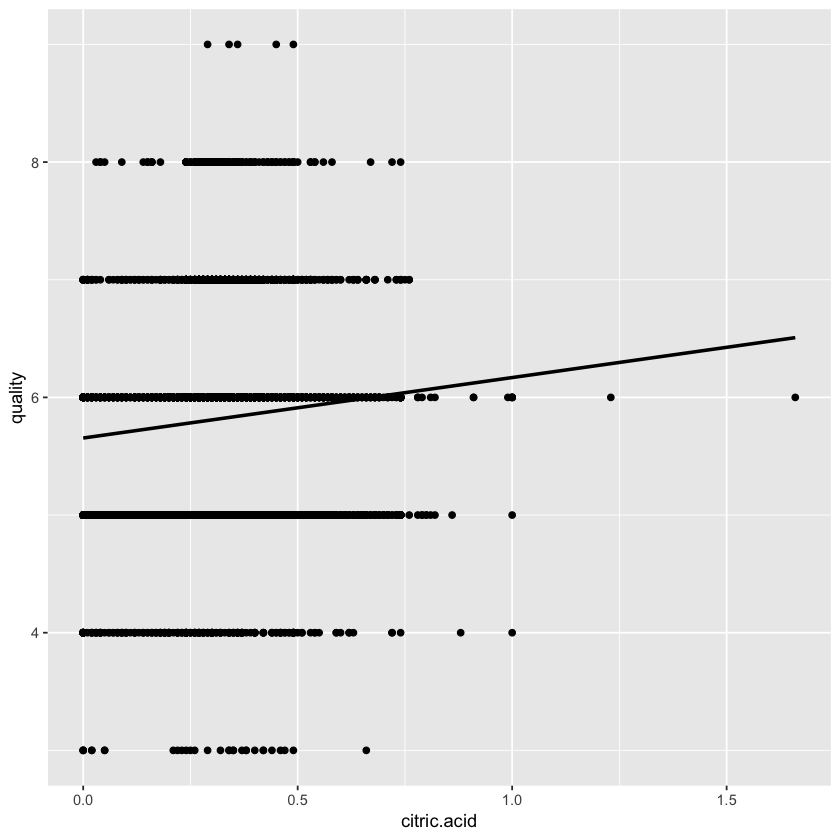

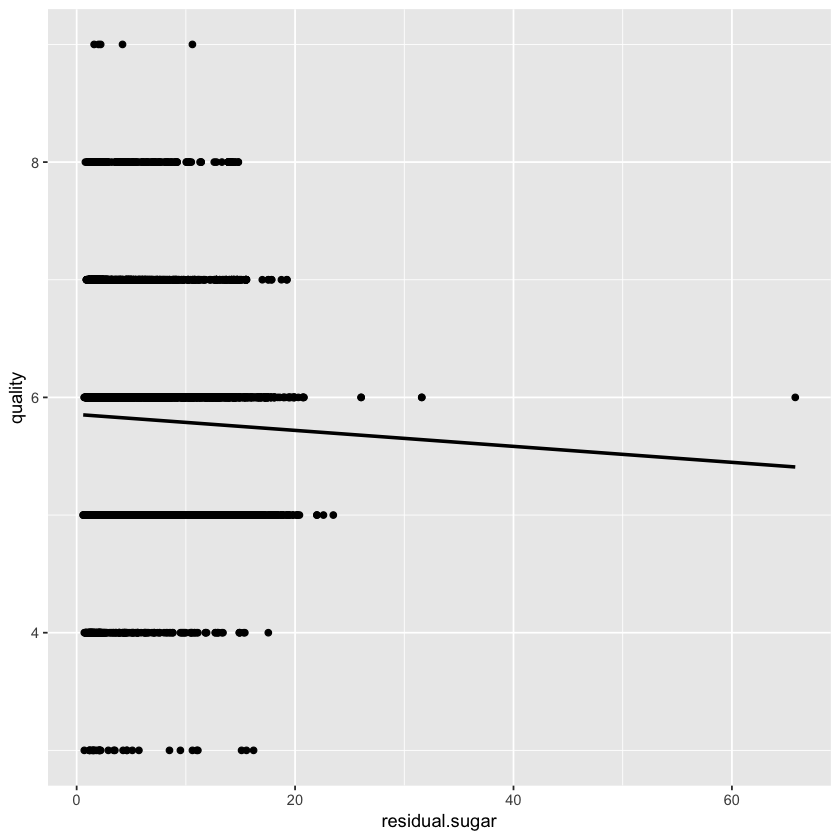

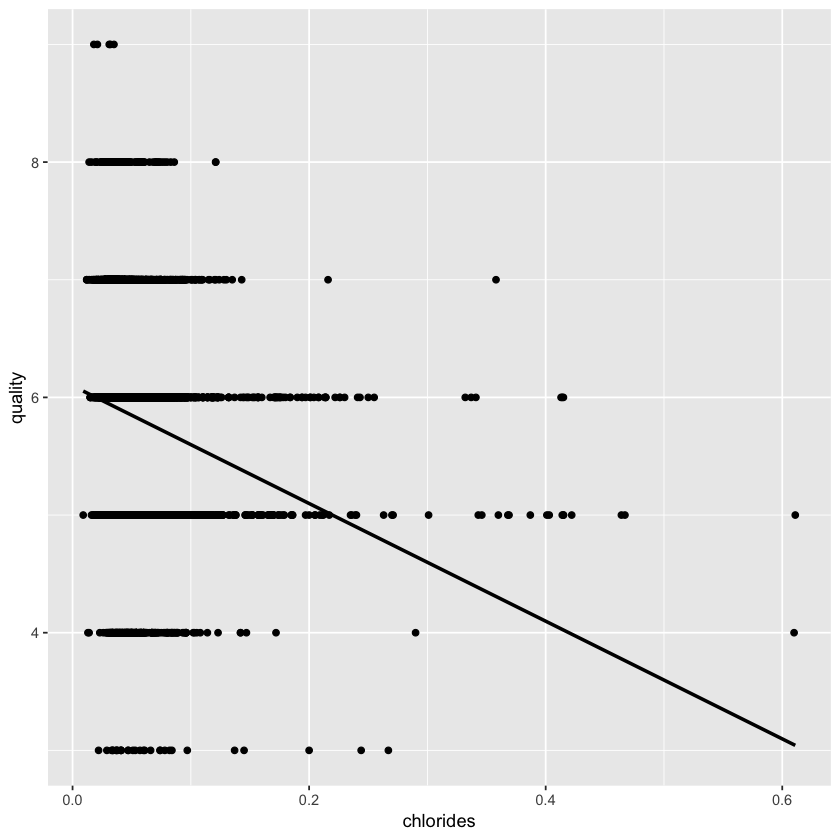

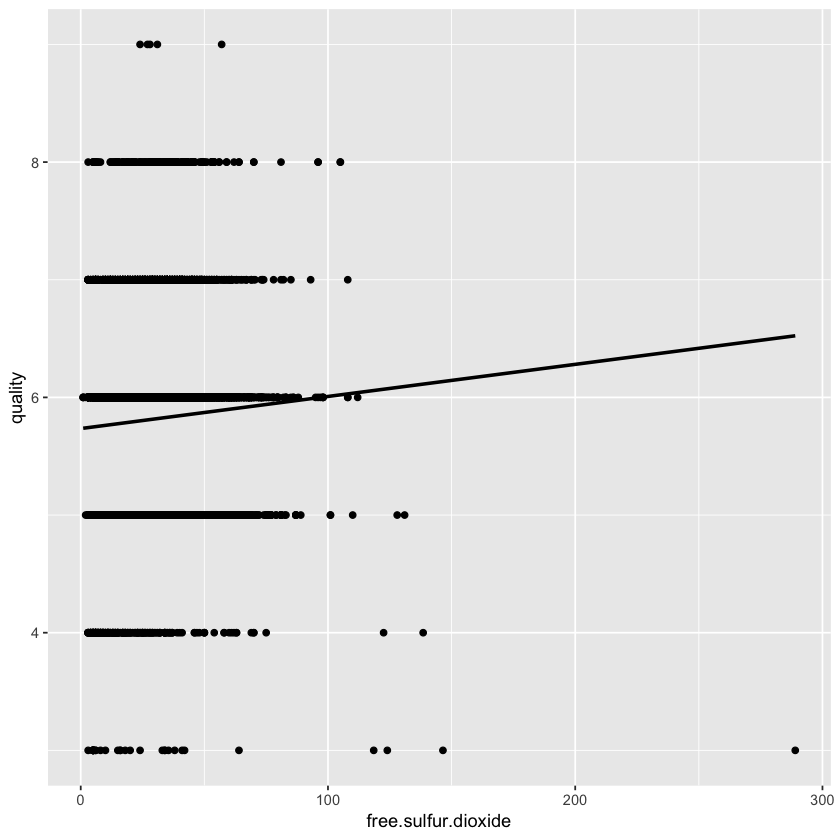

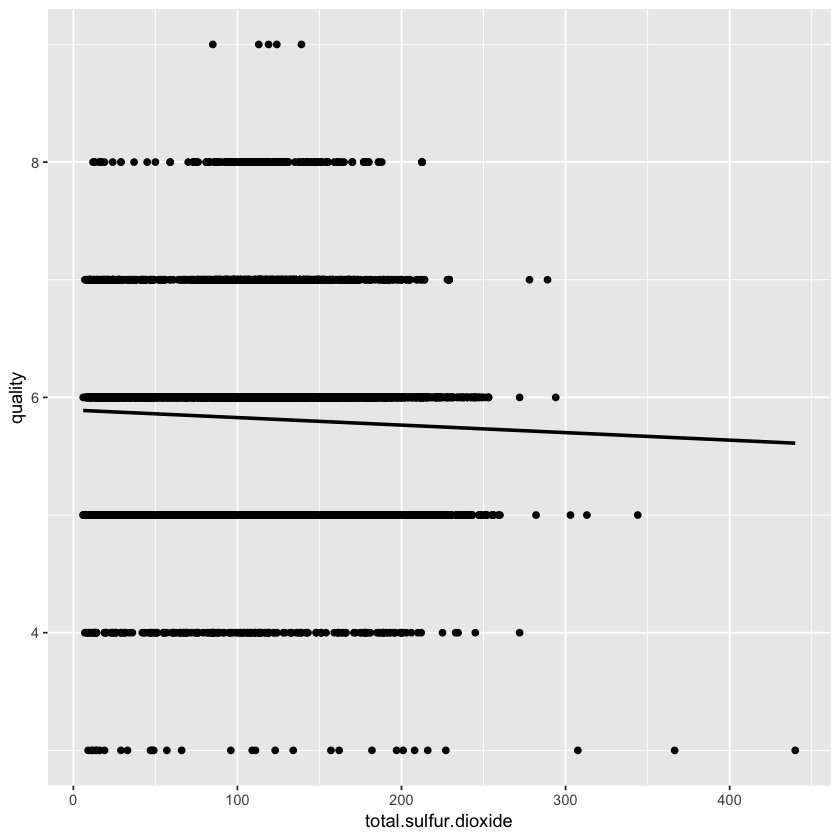

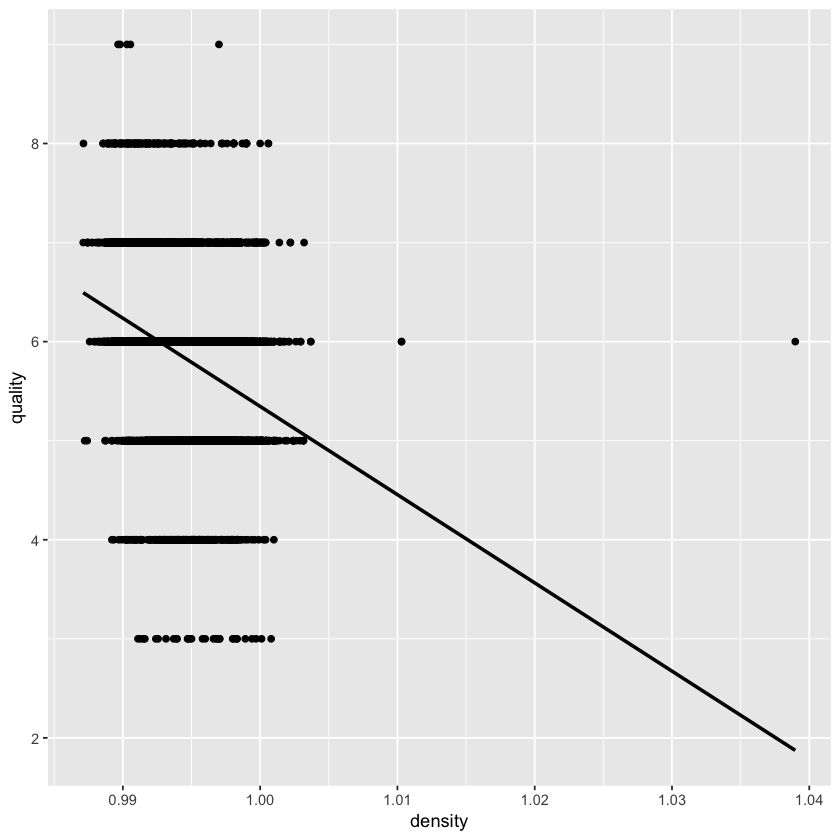

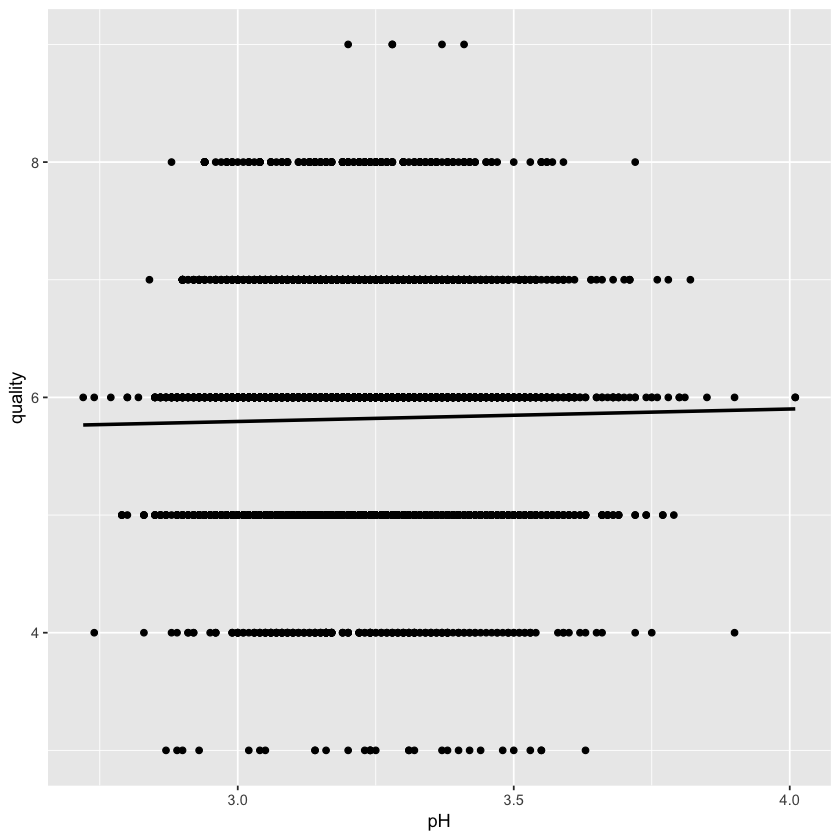

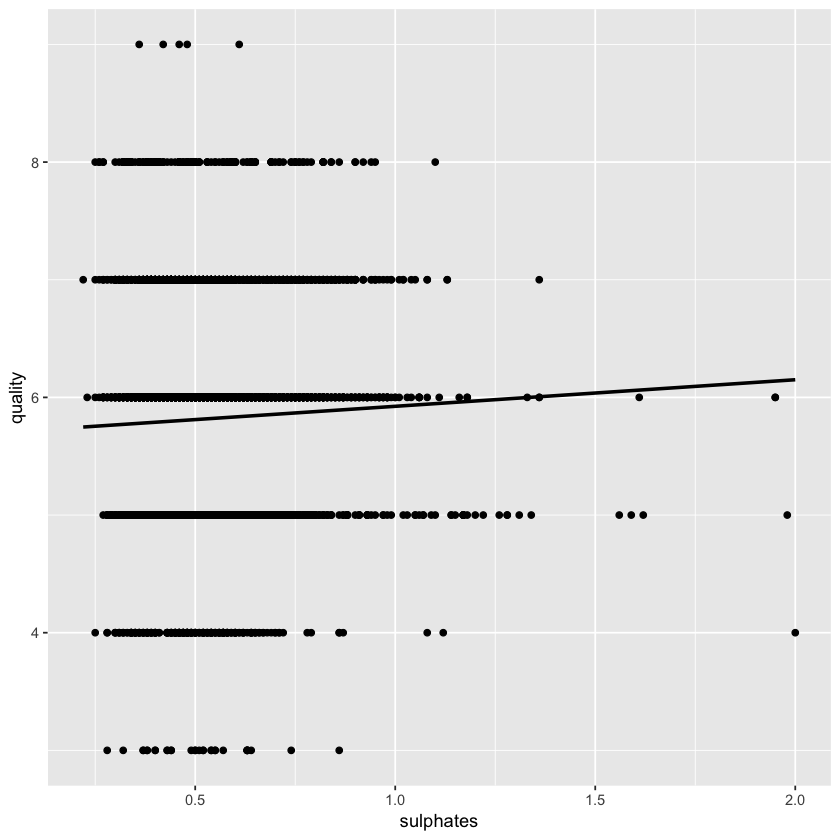

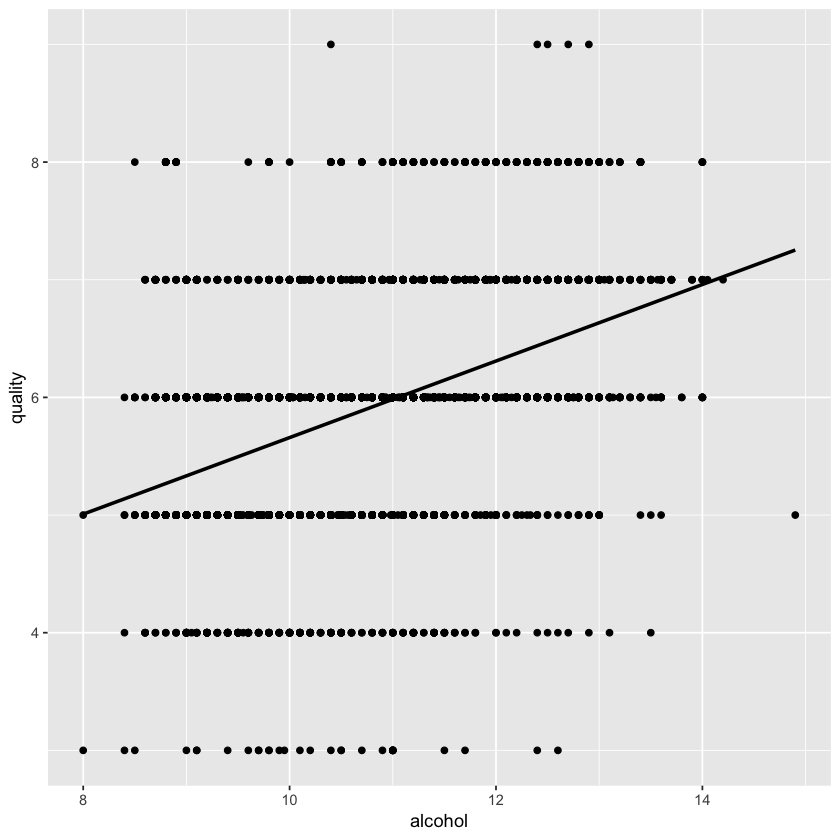

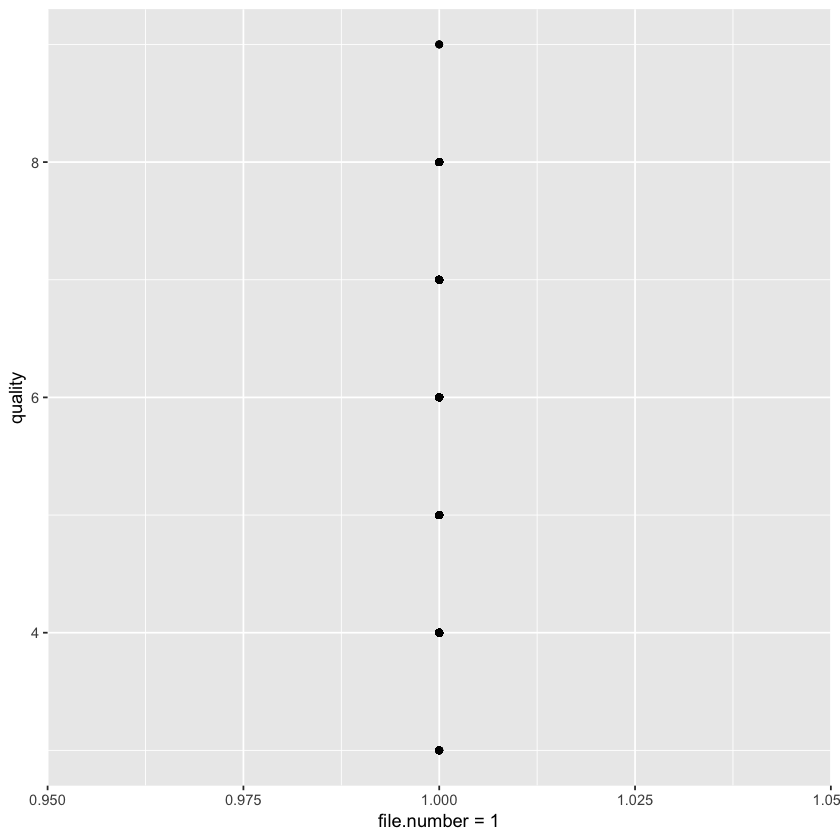

In [169]:
hp <- get_default_hyperparameters()
response_name <- attr(hp, "response_name")
data <- read_data(attr(hp, "files"))
#ggplot(data, aes_string(y = response_name, x = "pH")) + geom_point()
predictor_names <- colnames(data)[colnames(data) != response_name]
for(pred in predictor_names){
    p <- ggplot(data, aes_string(y = response_name, x = pred)) +
    geom_point() + geom_smooth(method = "lm", se = FALSE, col = "black")
    #print(p)
}
library(ggplot2)
library(GGally)
ggpairs(iris, columns=1:4, aes(color=Species)) + 
  ggtitle("Anderson's Iris Data -- 3 species")

library(lattice)
splom(iris[1:4], 
      groups=iris$Species, 
      main="Anderson's Iris Data -- 3 species")

In [205]:
#define shorter names for this specific dataset
#to help plotting
short_names <- function(){
    sn <- list(fixed.acidity="fix.acd",
               volatile.acidity="vol.acd",
                citric.acid="cit.acd",
                residual.sugar="res.sug",
                chlorides="chlor",
                free.sulfur.dioxide="fr.SO2",
                total.sulfur.dioxide="tot.SO2",
                density="dens",
                pH="pH",
                sulphates="sulph",
                alcohol="alc",
                file.number.1="red")
    return(sn)
}

In [234]:
#main function for EDA

reorder_cormat <- function(cormat){
    # Use correlation between variables as distance
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd)
    cormat <-cormat[hc$order, hc$order]
}

run_eda <- function(hyperparameters){
    main_url <- attr(hyperparameters, "main_url")
    files    <- attr(hyperparameters, "files")
    response_name <- attr(hyperparameters, "response_name")
    
    have_data <- find_or_download_data(main_url, files)
    if(!have_data){
        print("Could not find or download data - returning null")
        return(NULL)
    }
    else{
        data <- read_data(files)
        
        #plot relationship between each predictor and response
        predictor_names <- colnames(data)[colnames(data) != response_name]
        #for(x in predictor_names){
        #    ggplot(data, aes_string(y = response_name, x = x)) + geom_point()
        #}
        
        #ggally pairs plot struggles with 12 variables
        #base R pairs plot is OK
        
        ## ggally pairs plot:
        #pairplot_columns <- 1:length(colnames(data))
        #pairplot_columns <- pairplot_columns[colnames(data) != response_name]
        #pairplot <- ggpairs(data, columns=pairplot_columns) + 
        #  ggtitle("Pairs plot")
        #print(pairplot)
        
        ## base R pairs plot: 
        sn <- short_names()
        labels <- list()
        for (i in 1:length(predictor_names)){
            labels[i] <- sn[[predictor_names[i]]]
        }
        
        #pairs(data[,predictor_names], labels=labels, panel=points, pch = 16, cex = .5, xaxt = "n", yaxt = "n")
        
        predictors <- data[,predictor_names]
        colnames(predictors) <- labels
        
        cormat <- round(cor(predictors),2)
        cormat <- reorder_cormat(cormat)
        
        cormat[lower.tri(cormat)]<- NA
        
        # Melt the correlation matrix
        melted_cormat <- melt(cormat, na.rm = TRUE)
        # Heatmap
        ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
             geom_tile(color = "white")+
             scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
             midpoint = 0, limit = c(-1,1), space = "Lab", 
             name="Pearson\nCorrelation") +
             theme_minimal()+ 
             theme(axis.text.x = element_text(angle = 45, vjust = 1, 
             size = 12, hjust = 1))+
             coord_fixed()
        
        #print pairs of variables with largest absolute correlation values
        #cutoff <- 0.6
        #for (i in 1:dim(cormat)[1]){
        #    for(j in 1:dim(cormat)[2])
        #}
        cormat[diag(cormat)] <- NA
        melted_cormat <- melt(cormat, na.rm=TRUE)
        
        for 
        cutoff <- 0.6
        
        
    }
}

ERROR: Error in parse(text = x, srcfile = src): <text>:77:9: unexpected symbol
76:         for 
77:         cutoff
            ^


In [233]:
hp <- get_default_hyperparameters()
run_eda(hp)

        Var1     Var2 value
1        alc      alc  1.00
13       alc       pH  0.12
14        pH       pH  1.00
25       alc  vol.acd -0.04
26        pH  vol.acd  0.26
27   vol.acd  vol.acd  1.00
37       alc      red -0.03
38        pH      red  0.33
39   vol.acd      red  0.65
40       red      red  1.00
49       alc    chlor -0.26
50        pH    chlor  0.04
51   vol.acd    chlor  0.38
52       red    chlor  0.51
53     chlor    chlor  1.00
61       alc    sulph  0.00
62        pH    sulph  0.19
63   vol.acd    sulph  0.23
64       red    sulph  0.49
65     chlor    sulph  0.40
66     sulph    sulph  1.00
73       alc  fix.acd -0.10
74        pH  fix.acd -0.25
75   vol.acd  fix.acd  0.22
76       red  fix.acd  0.49
77     chlor  fix.acd  0.30
78     sulph  fix.acd  0.30
79   fix.acd  fix.acd  1.00
85       alc  cit.acd -0.01
86        pH  cit.acd -0.33
87   vol.acd  cit.acd -0.38
88       red  cit.acd -0.19
89     chlor  cit.acd  0.04
90     sulph  cit.acd  0.06
91   fix.acd  cit.ac

In [124]:
#main function for evaluating different approaches
evaluate_ensemble <- function(hyperparameters){

    
    verbose <- attr(hyperparameters, "verbose")
    K <- attr(hyperparameters, "ensemble_K")
    R <- attr(hyperparameters, "top_level_repeats")
    
    main_url <- attr(hyperparameters, "main_url")
    files    <- attr(hyperparameters, "files")
    response_name <- attr(hyperparameters, "response_name")
    
    have_data <- find_or_download_data(main_url, files)
    if(!have_data){
        print("Could not find or download data - returning null")
        return(NULL)
    }
    else{
        
        data <- read_data(files)
        
        data <- preprocess(data, response_name)
        
        CV_indices <- get_CV_folds(nrow(data), K)
        train_indices <- CV_indices[[1]]
        test_indices  <- CV_indices[[2]]
        
        score_matrix = matrix(0, R, K)
        
        for (r in 1:R){
            if(verbose){
                print(paste('Top-level repeat', r, sep=' '))
            }
            for (k in 1:K){
                if(verbose){
                    print(paste('Top-level CV fold', k, sep=' '))
                }
                if(attr(hyperparameters, "run_standard_model")){
                    #just fit one lm to original predictors
                    #for comparison
                    train_data <- data[train_indices[[k]],]
                    test_data  <- data[test_indices[[k]],]
                    model  <- lm(y ~ (.)^2, data=train_data)
                    score_matrix[r,k]  <- mean(abs(test_data$y- predict(model, newdata=test_data)))
                }
                else{
                    #first step: find an ensemble of models
                    #by searching the space of possible models
                    #(this is the space of 2^P possible subsets of all predictors)
                    outputs <- find_ensemble(data[train_indices[[k]],])
                    scores <- outputs[[1]]
                    ensemble_definitions <- outputs[[2]]
                    if(verbose){
                        print('Model definitions:')
                        print(ensemble_definitions)
                        print('Scores:')
                        print(scores)
                    }
                    #now train the ensemble on the same data
                    ensemble_models <- train_ensemble(ensemble_definitions, data[train_indices[[k]],])
                    predictions <- run_ensemble(ensemble_models, data[test_indices[[k]],], scores, hyperparameters)
                    score_matrix[r,k] <- mean(abs(predictions - data$y[test_indices[[k]]]))
                    #print(paste("Ensemble score =",score,sep=" "))
                }
            }
        }
    }
    dim(scores) <- NULL
    return(scores)
}

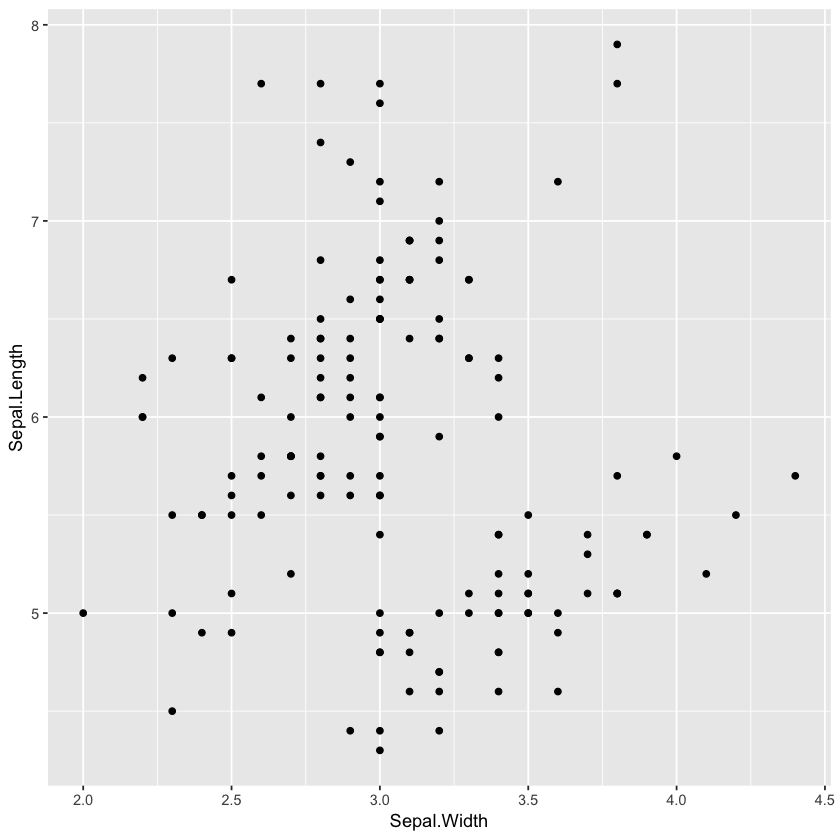

In [157]:
ggplot(iris, aes_string(y = "Sepal.Length", x = "Sepal.Width")) + geom_point()

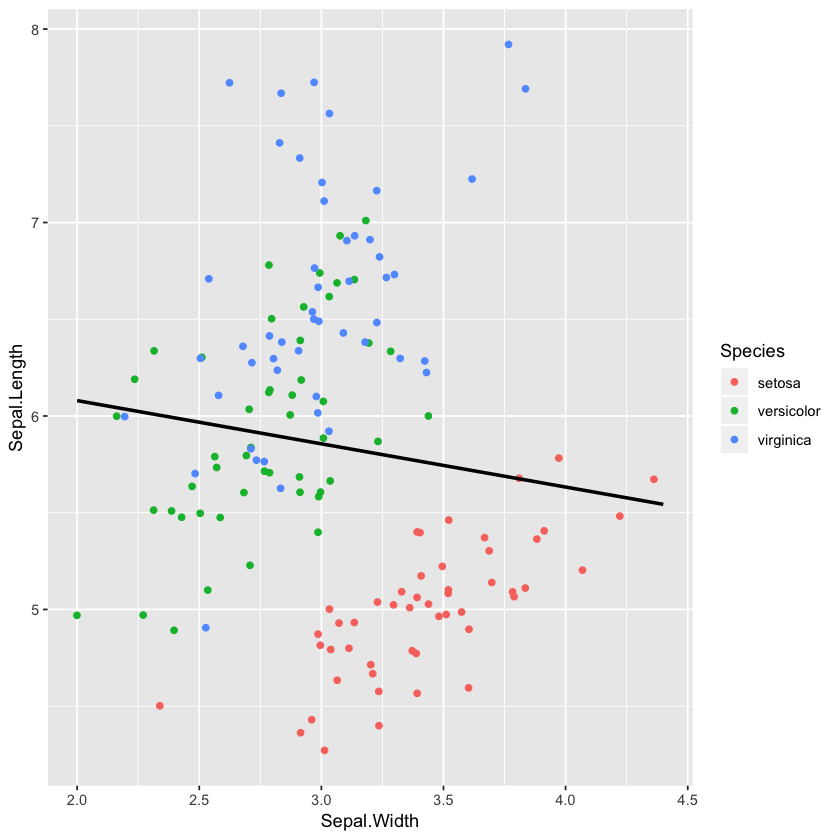

In [154]:
ggplot(iris, aes_string(y = "Sepal.Length", x = "Sepal.Width")) + geom_point()
  geom_jitter(aes_string(col = "Species")) +
  geom_smooth(method = "lm", se = FALSE, col = "black")

In [130]:
#top level code: define hyperparameters, run ensemble
hp <- get_default_hyperparameters()

attr(hp, "verbose") <- TRUE

attr(hp, "run_standard_model") <- TRUE
scores_1 <- evaluate_ensemble(hp)
attr(hp, "run_standard_model") <- FALSE
scores_2 <- evaluate_ensemble(hp)

print(paste("mean of scores_1 = ", mean(scores_1), sep=" "))
print(paste("mean of scores_2 = ", mean(scores_2), sep=" "))
print(paste("SEM of scores_1 = ", sd(scores_1)/sqrt(length(scores_1)), sep=" "))
print(paste("SEM of scores_2 = ", sd(scores_2)/sqrt(length(scores_2)), sep=" "))

[1] "Top-level repeat 1"
[1] "Top-level CV fold 1"
[1] "Top-level CV fold 2"
[1] "Top-level CV fold 3"
[1] "Top-level CV fold 4"
[1] "Top-level CV fold 5"
[1] "Top-level repeat 2"
[1] "Top-level CV fold 1"
[1] "Top-level CV fold 2"
[1] "Top-level CV fold 3"
[1] "Top-level CV fold 4"
[1] "Top-level CV fold 5"
[1] "Top-level repeat 3"
[1] "Top-level CV fold 1"
[1] "Top-level CV fold 2"
[1] "Top-level CV fold 3"
[1] "Top-level CV fold 4"
[1] "Top-level CV fold 5"
[1] "Top-level repeat 4"
[1] "Top-level CV fold 1"
[1] "Top-level CV fold 2"
[1] "Top-level CV fold 3"
[1] "Top-level CV fold 4"
[1] "Top-level CV fold 5"
[1] "Top-level repeat 5"
[1] "Top-level CV fold 1"
[1] "Top-level CV fold 2"
[1] "Top-level CV fold 3"
[1] "Top-level CV fold 4"
[1] "Top-level CV fold 5"
[1] "Top-level repeat 6"
[1] "Top-level CV fold 1"
[1] "Top-level CV fold 2"
[1] "Top-level CV fold 3"
[1] "Top-level CV fold 4"
[1] "Top-level CV fold 5"
[1] "Top-level repeat 7"
[1] "Top-level CV fold 1"
[1] "Top-level CV f

Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“long

“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning me

[1] "Model definitions:"
[[1]]
[1] "total.sulfur.dioxide" "citric.acid"          "chlorides"           

[[2]]
[1] "fixed.acidity"        "residual.sugar"       "sulphates"           
[4] "free.sulfur.dioxide"  "file.number=1"        "chlorides"           
[7] "total.sulfur.dioxide"

[[3]]
[1] "pH"                   "total.sulfur.dioxide" "free.sulfur.dioxide" 
[4] "fixed.acidity"        "alcohol"              "volatile.acidity"    
[7] "density"              "sulphates"           

[1] "Scores:"
[1] 0.9393330 0.9085812 0.8224934
[1] "Top-level CV fold 2"


Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“long

[1] "Model definitions:"
[[1]]
[1] "fixed.acidity"        "total.sulfur.dioxide" "residual.sugar"      
[4] "sulphates"            "density"              "volatile.acidity"    
[7] "chlorides"           

[[2]]
[1] "residual.sugar"      "alcohol"             "free.sulfur.dioxide"
[4] "sulphates"           "file.number=1"       "citric.acid"        
[7] "chlorides"           "volatile.acidity"   

[[3]]
[1] "free.sulfur.dioxide"  "file.number=1"        "sulphates"           
[4] "chlorides"            "total.sulfur.dioxide" "pH"                  
[7] "residual.sugar"       "volatile.acidity"    

[1] "Scores:"
[1] 0.8529781 0.8198950 0.8877410
[1] "Top-level CV fold 3"


Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4157 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4157 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“long

“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4157 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4157 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning me

[1] "Model definitions:"
[[1]]
[1] "pH"                   "free.sulfur.dioxide"  "sulphates"           
[4] "residual.sugar"       "density"              "file.number=1"       
[7] "fixed.acidity"        "total.sulfur.dioxide" "volatile.acidity"    

[[2]]
[1] "fixed.acidity"    "file.number=1"    "chlorides"        "sulphates"       
[5] "volatile.acidity" "pH"              

[[3]]
[1] "fixed.acidity"        "file.number=1"        "total.sulfur.dioxide"

[1] "Scores:"
[1] 0.8263509 0.9103864 0.9634466
[1] "Top-level CV fold 4"


Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“long

[1] "Model definitions:"
[[1]]
[1] "pH"            "sulphates"     "citric.acid"   "file.number=1"
[5] "fixed.acidity" "density"       "alcohol"      

[[2]]
[1] "free.sulfur.dioxide"  "file.number=1"        "total.sulfur.dioxide"
[4] "sulphates"            "residual.sugar"       "chlorides"           
[7] "density"              "alcohol"              "fixed.acidity"       

[[3]]
[1] "pH"                   "free.sulfur.dioxide"  "chlorides"           
[4] "total.sulfur.dioxide" "sulphates"            "residual.sugar"      

[1] "Scores:"
[1] 0.8649320 0.8450719 0.9199405
[1] "Top-level CV fold 5"


Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4157 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4157 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“long

“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4157 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4157 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning me

“'newdata' had 1040 rows but variables found have 4157 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4157 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”

[1] "Model definitions:"
[[1]]
NULL

[[2]]
[1] "pH"                  "chlorides"           "file.number=1"      
[4] "free.sulfur.dioxide" "volatile.acidity"   

[[3]]
[1] "total.sulfur.dioxide" "density"              "file.number=1"       
[4] "chlorides"            "citric.acid"          "volatile.acidity"    
[7] "fixed.acidity"        "alcohol"             

[1] "Scores:"
[1] 1.0000000 0.9186699 0.8344566
[1] "Top-level repeat 2"
[1] "Top-level CV fold 1"


Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“long

“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning me

“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length 

[1] "Model definitions:"
[[1]]
NULL

[[2]]
NULL

[[3]]
[1] "fixed.acidity"       "file.number=1"       "chlorides"          
[4] "free.sulfur.dioxide" "sulphates"           "citric.acid"        
[7] "alcohol"             "density"            

[1] "Scores:"
[1] 1.000000 1.000000 0.863886
[1] "Top-level CV fold 2"


Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“long

“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning me

“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1039 rows but variables found have 4159 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length is not a multiple of shorter object length”Warning message:
“'newdata' had 1040 rows but variables found have 4158 rows”Warning message in test_data$y - predict(model, newdata = test_data):
“longer object length 

[1] "Model definitions:"
[[1]]
[1] "residual.sugar"

[[2]]
[1] "residual.sugar"

[[3]]
[1] "sulphates"            "chlorides"            "total.sulfur.dioxide"
[4] "citric.acid"          "density"              "pH"                  

[1] "Scores:"
[1] 0.9997583 0.9994669 0.9028647


ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [2] not equal to array extent
